In [9]:
import numpy as np
import pysindy as ps
import random
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
from matplotlib import style
style.use('seaborn-white')

In [10]:
def cartPoleDyn(ts, theta, theta_d, x, x_d):
    m1 = 1
    m2 = 0.1
    length = 0.5
    k_inertia = 1/3
    mu_c = 0.0005
    mu_p = 0.000002
    gravity = 9.8
    force = -0.2+0.5*np.sin(6*ts) # np.random.choice([-2,2], size=1, replace=True)
    dt = 0.001
    theta_dd = ((m1+m2)*gravity*np.sin(theta)-np.cos(theta)*(force+m2*length*(theta_d**2)*np.sin(theta)-mu_c*x_d)-((m1+m2)*mu_p*theta_d)/(m2*length)) / ((m1+m2)*(k_inertia+1)*length - m2*length*(np.cos(theta))**2)
    x_dd = (force-m2*length*(theta_dd*np.cos(theta)-(theta_d**2)*np.sin(theta))-mu_c*x_d) / (m1+m2)
    # Euler Integrator 
    x_d = x_d + x_dd*dt
    x = x + x_d*dt
    theta_d = theta_d + theta_dd*dt
    theta = theta + theta_d*dt
    return theta_dd, theta_d, theta, x_dd, x_d,  x 

In [11]:
# Initialization 
theta = 0.3 # np.random.uniform(low=-0.05, high=0.05)
theta_d = 1 # np.random.uniform(low=-0.05, high=0.05)
x = 0 # np.random.uniform(low=-0.05, high=0.05)
x_d = 0 # np.random.uniform(low=-0.05, high=0.05)

# lists for storing results 
theta_dd_sim = []
theta_d_sim = [theta_d]
theta_sim = [theta]
x_dd_sim = []
x_d_sim = [x_d]
x_sim = [x]

noOfSteps = 22000
ts = np.linspace(0, noOfSteps/1000, num=noOfSteps, endpoint=False)

for i in range(noOfSteps):
    theta_dd, theta_d, theta, x_dd, x_d, x = cartPoleDyn(ts[i], theta, theta_d, x, x_d)
    theta_dd_sim.append(theta_dd)
    theta_d_sim.append(theta_d)
    theta_sim.append(theta)
    x_dd_sim.append(x_dd)
    x_d_sim.append(x_d)
    x_sim.append(x)    

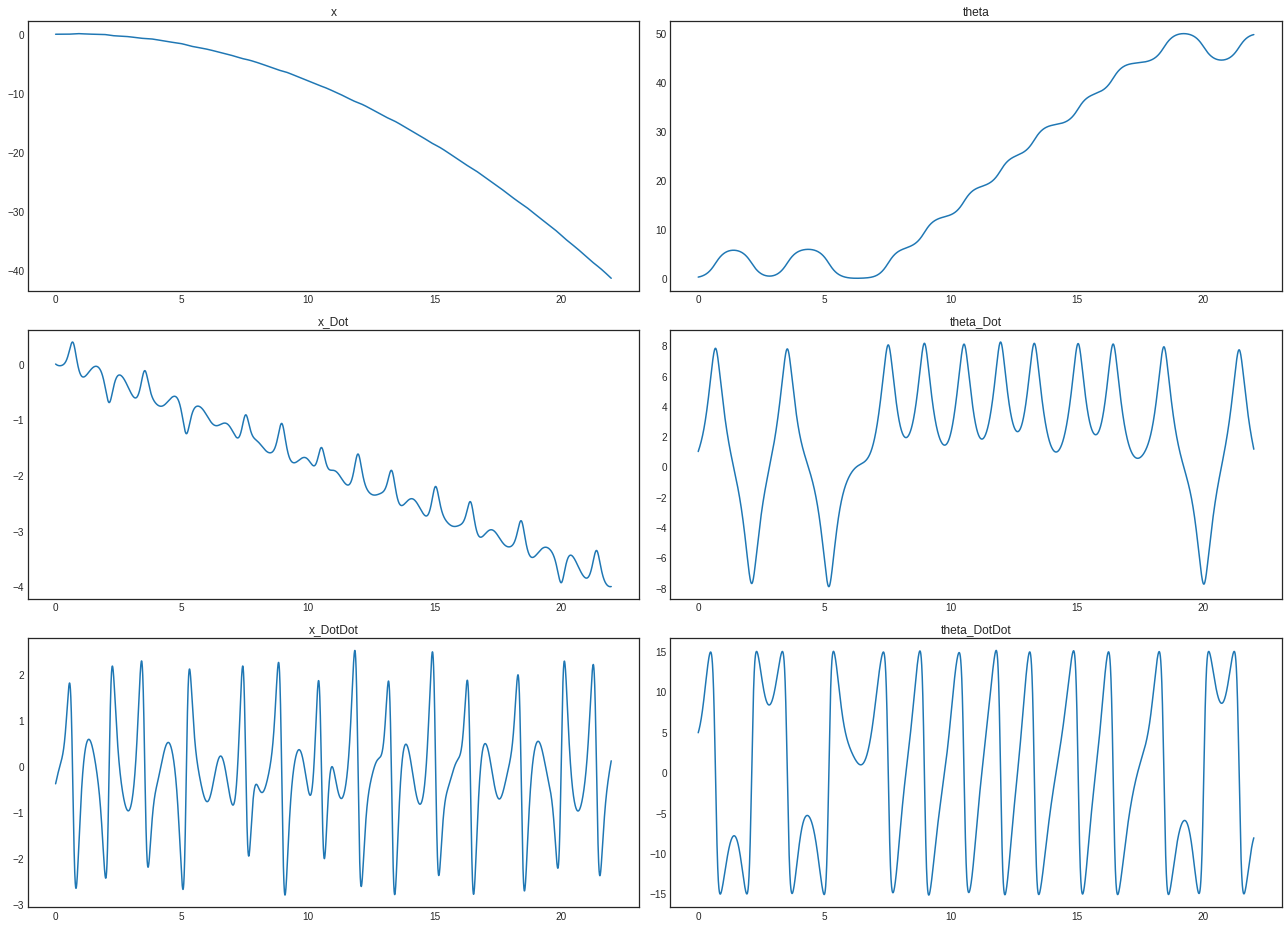

In [12]:
# Converting to Numpy Arrays for Plotting
theta_dd_sim = np.array(theta_dd_sim)
theta_d_sim = np.array(theta_d_sim)
theta_sim = np.array(theta_sim)
x_dd_sim = np.array(x_dd_sim)
x_d_sim = np.array(x_d_sim)
x_sim = np.array(x_sim)

timeSteps = np.linspace(0, noOfSteps/1000, num=noOfSteps, endpoint=False)

# Plotting 
fig, axs = plt.subplots(3, 2)

fig.set_figheight(13)
fig.set_figwidth(18)

axs[0, 0].plot(timeSteps, x_sim[:-1])
axs[0, 0].set_title("x")
axs[1, 0].plot(timeSteps, x_d_sim[:-1])
axs[1, 0].set_title("x_Dot")
axs[2, 0].plot(timeSteps, x_dd_sim)
axs[2, 0].set_title("x_DotDot")
#axs[1, 0].sharex(axs[0, 0])
axs[0, 1].plot(timeSteps, theta_sim[:-1])
axs[0, 1].set_title("theta")
axs[1, 1].plot(timeSteps, theta_d_sim[:-1])
axs[1, 1].set_title("theta_Dot")
axs[2, 1].plot(timeSteps, theta_dd_sim)
axs[2, 1].set_title("theta_DotDot")
fig.tight_layout()

Text(0.5, 1.0, 'A single plot')

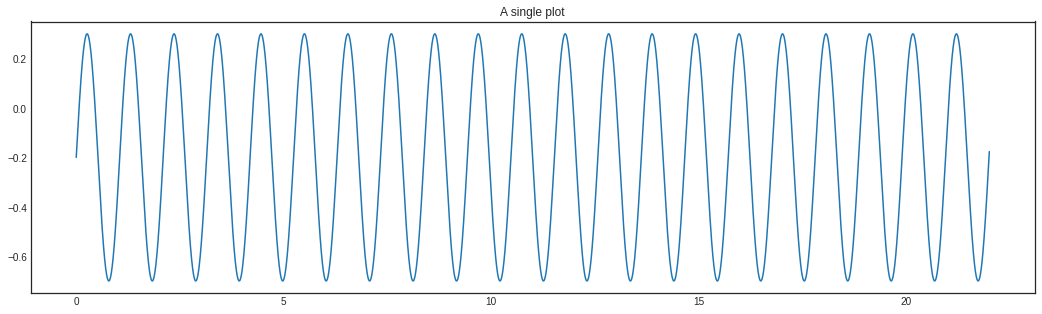

In [13]:
forceIn = -0.2+0.5*np.sin(6*timeSteps)
fig, ax = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(18)

ax.plot(timeSteps, forceIn)
ax.set_title('A single plot')

# SINDYc

In [79]:
# Fit the model 
dt = 0.001
poly_order = 2
trunc_traj = 0
end_traj = 99999

ts = np.linspace(0, noOfSteps/1000, num=noOfSteps, endpoint=False)
forceIn = -0.2+0.5*np.sin(6*ts)

x_train = np.stack((theta_d_sim[trunc_traj:end_traj],x_d_sim[trunc_traj:end_traj],forceIn[trunc_traj:end_traj]), axis=-1)
y_train = np.stack((theta_dd_sim[trunc_traj:end_traj],x_dd_sim[trunc_traj:end_traj]), axis=-1)
u_input = forceIn[trunc_traj:end_traj] # if change this then change below

feature_library1 = ps.FourierLibrary(n_frequencies=2) 
feature_library2 = ps.PolynomialLibrary(degree=poly_order)
feature_library3 = ps.FourierLibrary() + ps.PolynomialLibrary(degree=poly_order)

models = []
mseAll = []
threshFourierDecKoi = [0.1]
threshPoly = [0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
threshFourierDec = [0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
threshFourierFollow = [0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

t_test = np.arange(0, 3, dt)
test_start = 12999
startTrajTest = test_start        # for plotting and u
endTrajTest = startTrajTest + 3000 # for plotting and u
u_test_sim = forceIn[startTrajTest:endTrajTest]
start_sim = np.array([theta_d_sim[test_start],x_d_sim[test_start]])
test_sim = np.stack((theta_dd_sim[startTrajTest:endTrajTest-1],x_dd_sim[startTrajTest:endTrajTest-1]), axis=-1)

feature_names = ['t', 'x', 'f']
for threshold in threshFourierDec:
    model = ps.SINDy(optimizer=ps.STLSQ(threshold=threshold),
                 feature_library=feature_library1,feature_names=feature_names)

    model.fit(x_train[:,:2], t=dt, x_dot=y_train, u=u_input, quiet=True)
    models.append(model)
    x_test = model.simulate(start_sim, t_test, u=u_test_sim)
    mse = mean_squared_error(x_train[startTrajTest:endTrajTest-1,:2], x_test)
    mseAll.append(mse)

/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/pysindy/pysindy.py:790: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  "Last time point dropped in simulation because interpolation"
/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/pysindy/pysindy.py:790: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  "Last time point dropped in simulation because interpolation"
/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/pysindy/pysindy.py:790: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  "Last time point dropped in simulation because interpolation"
/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/pysindy/pysindy.py:790: UserWarning: Last time point dropped 

0.3
t' = -2.349 sin(1 f) + 2.090 sin(2 f)
x' = 1.104 sin(1 f)


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/pysindy/pysindy.py:790: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  "Last time point dropped in simulation because interpolation"


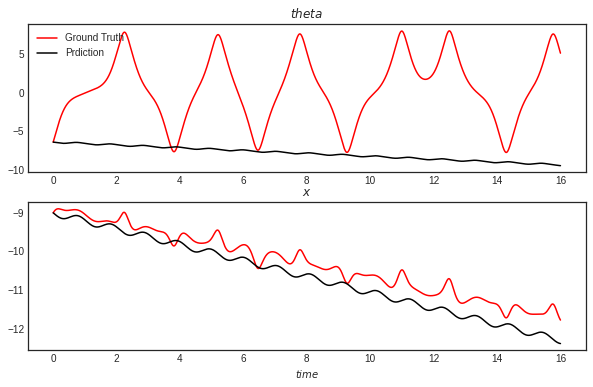

In [75]:
#print(mseAll)
print(threshFourierDec[np.argmin(mseAll)])
model = models[np.argmin(mseAll)]
#model = models[1]
model.print()
# Simulate the model 

t_test = np.arange(0, 16, dt)

sim_start = 50000
startTraj = sim_start      # for plotting and u
endTraj = startTraj + 16000 # for plotting and u


u_test_sim = forceIn[startTraj:endTraj]
x_sim = model.simulate(x_train[sim_start,:2], t_test, u=u_test_sim)

fig, ax = plt.subplots(2) 

fig.set_figheight(6)
fig.set_figwidth(10)

g1, = ax[0].plot(t_test, x_train[startTraj:endTraj,0], "r")
p1, = ax[0].plot(t_test[1:], x_sim[:,0], "k")
ax[0].set_title('$theta$')
ax[0].legend((g1, p1), ('Ground Truth', 'Prdiction'), loc='upper left', shadow=False)
plt.xlabel("$time$")

ax[1].plot(t_test, x_train[startTraj:endTraj,1], "r")
ax[1].plot(t_test[1:], x_sim[:,1], "k")
ax[1].set_title('$x$')
plt.show()

Mean-Squared Error is 55.62402342687547


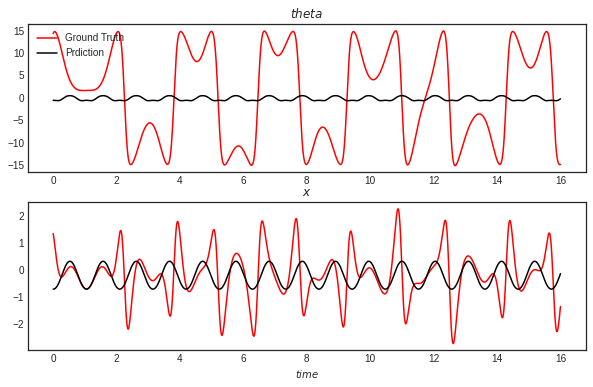

In [76]:
# Plotting derivatives on training dataset 
model = models[np.argmin(mseAll)]

xDotPredicted = model.predict(x_train[startTraj:endTraj,:2], u=u_test_sim)
print("Mean-Squared Error is", mean_squared_error(xDotPredicted, y_train[startTraj:endTraj, :]))
#xDotTruth = model.differentiate(v[startTraj:endTraj], t=tPred)

fig, ax = plt.subplots(2) 

fig.set_figheight(6)
fig.set_figwidth(10)

g1, = ax[0].plot(t_test, y_train[startTraj:endTraj,0], "r")
p1, = ax[0].plot(t_test, xDotPredicted[:,0], "k")
ax[0].set_title('$theta$')
ax[0].legend((g1, p1), ('Ground Truth', 'Prdiction'), loc='upper left', shadow=False)
plt.xlabel("$time$")

ax[1].plot(t_test, y_train[startTraj:endTraj,1], "r")
ax[1].plot(t_test, xDotPredicted[:,1], "k")
ax[1].set_title('$x$')
plt.show()

In [9]:
np.arange(0, 3, 0.001).size

3000